In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pipetorch import DFrame
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt


# stap 1

In [2]:
#Import dataset to df
df = pd.read_csv('Datasets Foodboost/ingredients.csv')

#Create empty dictionary
notenDict = {}

#Create empty lists
safeList = []
unsafeList = []

In [3]:
def filterFunc(inputString):
    notenLijst = ["noot","pinda","eikel","amandel","cashew","hazelno","hican","hickory","kemirie","macadamia","nangaino","parano","pecan","pistache","kastanje","walnoot","betelno","beukenno"]
    falsePositives = ["muskaat"]
    for i in falsePositives:
        if i in inputString:
            return False
    for o in notenLijst:
        if o in inputString:
            return True
    return False

In [4]:
#Iterate over every row in the dataset
for i in df.itertuples():
    #If the recipe is not in the ductionary, add it.
    if not i[2] in notenDict.keys():
        notenDict[i[2]] = False
    
    #If the current row has an ingredient that contains nuts, set the ingredient in the dictionary to True
    if filterFunc(i[3]):
        notenDict[i[2]] = True

#Append recipes to corresponding lists.
for i in notenDict:
    
    if notenDict[i]:
        unsafeList.append(i)
    else:
        safeList.append(i)
        
#Convert Dictionary to DataFrame
outputDF = pd.DataFrame.from_dict(notenDict,orient='index')
print(outputDF.head())

                                        0
Kruidnoten met choco-discodip       False
Kruidnoten in marsepein             False
Kruidnoten met chocodips            False
Pepernotentaart met marsepeinstrik  False
Perencake                           False


In [5]:
outputDF.rename(columns={0: "noten"},inplace=True)
outputDF

,noten
Kruidnoten met choco-discodip,False
Kruidnoten in marsepein,False
Kruidnoten met chocodips,False
Pepernotentaart met marsepeinstrik,False
Perencake,False
...,...
Paddenstoelen en courgettegratin,False
Peren-amandelcoupe,True
Ceviche met sint-jakobsschelpen,False
Pittige truffels,False


In [6]:
tags = pd.read_csv('/data/foodboost/tags.csv')

In [7]:
tagsmaal= ['lunch','diner','hoofdgerecht']
maaltijd_alles = tags[tags['tag'].str.contains('|'.join(tagsmaal))]
maaltijd_alles=maaltijd_alles.drop_duplicates(subset=['recipe'], keep= 'first')
maaltijd_alles = maaltijd_alles.set_index('recipe')

zonder_noten= outputDF[outputDF["noten"]==False]
DF_noten_maaltijd =pd.merge(zonder_noten, maaltijd_alles, left_index=True, right_index=True)
DF_noten_maaltijd= DF_noten_maaltijd[["noten","tag"]]
DF_noten_maaltijd

,noten,tag
Tartiflette,False,hoofdgerecht
Ajam pangang,False,hoofdgerecht
Bloemkoolschotel,False,hoofdgerecht
Koe loe kai,False,hoofdgerecht
Pasta pesto met kipstuckjes en tomatensalade,False,hoofdgerecht
...,...,...
Romige spaghetti met zalmreepjes,False,hoofdgerecht
Tijmballetjes met puree,False,hoofdgerecht
Romige mosselen met dille,False,hoofdgerecht
Mosselen op z'n Thais,False,hoofdgerecht


# stap 2

In [8]:
#recepten_df=pd.read_csv("Generated Datasets/Filter_noten_maaltijd_DF.csv")
recepten = list(DF_noten_maaltijd.index)

tags = pd.read_csv('/data/foodboost/tags.csv')
tags = tags[tags['recipe'].str.contains('|'.join(recepten))]

/tmp/ipykernel_33226/2275862206.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tags = tags[tags['recipe'].str.contains('|'.join(recepten))]


In [9]:
tags_pivot = tags.pivot_table(values="recipe", index= tags.recipe, columns="tag", aggfunc="count")
tags_pivot= tags_pivot.fillna(0) 

In [10]:
ingr = pd.read_csv('/data/foodboost/ingredients.csv')
ingr = ingr[ingr['recipe'].str.contains('|'.join(recepten))]

ingr_pivot = ingr.pivot_table(values="recipe", index= ingr.recipe, columns="ingredient", aggfunc="count")
ingr_pivot= ingr_pivot.fillna(0) 
ingr_pivot

/tmp/ipykernel_33226/236294688.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ingr = ingr[ingr['recipe'].str.contains('|'.join(recepten))]


ingredient,(arachide)olie,(herten)biefstukken,(houdbare) melk,(magere) shoarmareepjes,(olijf)olie,(scharrel)braadworst,(wilde) perzik,(witte) quinoa,(wittewijn)azijn,(zonnebloem)olie,...,zwarte peperkorrels,zwarte quinoa,zwarte rijst,zwarte sesamzaadje,zwarte tagliatelle,zwarte-peperkorrel,zwarte-peperkorrels,zwarteolijvenplakjes,zwartepeperkorrel,zwijnsteak
recipe,,,,,,,,,,,,,,,,,,,,,
Andijviestamppot met gebakken salami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Libanese wraps met appel-koolsalade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plaattaart met gegrilde groenten en witte kaas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalmspies met sojaglaze van de BBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&amp;Suus’ buik-weg-salade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zweedse gehaktballetjes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zweedse gehaktballetjes met room,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zweedse vegaballetjes met aardappel &amp; broccoli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ingr_pivot_columnnames= ingr_pivot.columns.values.tolist()
lengte= len(ingr_pivot_columnnames)
dubbele_ingr= []
grens_ratio= 85
ingr_pivot_copy= ingr_pivot.copy()

In [12]:
for i in range(lengte):
    if i < (lengte-1):
        Ratio = fuzz.token_sort_ratio(ingr_pivot_columnnames[i],ingr_pivot_columnnames[i+1])
        if Ratio > grens_ratio:
            dubbele_ingr.append((ingr_pivot_columnnames[i], ingr_pivot_columnnames[i+1]))

In [13]:
ingr_pivot_copy= ingr_pivot.copy()
for i in dubbele_ingr:
    ingr_pivot_copy[i[1]] = ingr_pivot_copy[i[0]] + ingr_pivot_copy[i[1]]
    ingr_pivot_copy=ingr_pivot_copy.drop([i[0]], axis=1)

In [14]:
#ingr_pivot_copy.to_csv('ingr_pivot_lunch_diner_noten.csv')

# stap 3

In [15]:
df = ingr_pivot_copy
#Get rid of ingredients that aren't used at least 40 times.
ValidDf= df.loc[:,df.sum() > 40][df.sum(axis=1) != 0]
ValidDf

ingredient,(arachide)olie,(olijf)olie,Franse mosterd,Griekse yoghurt,Japanse sojasaus,Parmezaanse kaas,Parmigiano Reggiano,Pecorino Romano (kaas),Tasty Tom trostomaat,aardappelen,...,water,winterpeen,witlof,witte kaas 45+,witte rijst,zilvervliesrijst,zoete aardappel,zoete chilisaus,zonnebloemolie,zout
recipe,,,,,,,,,,,,,,,,,,,,,
Andijviestamppot met gebakken salami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Libanese wraps met appel-koolsalade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plaattaart met gegrilde groenten en witte kaas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalmspies met sojaglaze van de BBQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
&amp;Suus’ buik-weg-salade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zweedse gehaktballetjes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zweedse gehaktballetjes met room,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zweedse vegaballetjes met aardappel &amp; broccoli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#dict_jesse ={'Mexicaanse rijstschotel met kip':1,'Caponata met couscous':0,'Boerenkool-knolselderijstamp met rookworstcroutons':1,'Witlof met ham en kaas uit de oven':0,'Pittige vis-courgettekoekjes':1,'Aziatisch gemarineerde varkensspies met Chinese wokgroente':1,'Varkensfilet in peper-citroenkorst met pastinaak en peen':1,'Oosterse snijbonensalade met varkenshaas':1,'Bloemkoolquiche met oude kaas':0,'Sushisandwich met rivierkreeftjes &amp: avocado':1,'Pasta met aardappel, kip en sperziebonen':1,'Briequiche met appel':0,'Paddenstoelenpasteitje':1,'Kalkoen met salie':0,'Mediterrane eendenbouten met truffelpolenta &amp; parmezaan':1,'Fluitpasta':1,'Hollandse kaasfondue':0,'Noedels met mango &amp; kip':1,'Sjalotten-geitenkaasquiche met croutons':0,'Zoetzure filetlapjes met paksoi':1,"Stéphane Reynaud's gestoofde sla":1,'Tagliatelle met zalm en avocadopesto':1,'Noedels met ijsgarnalen en mango':1,'Stoere chili':1,'Vega gehakt van tofu met mie en paksoi':0,'Gebakken kabeljauw met aardappel-komkommersalade':1,'Fattoush met pita, kruiden en tuinerwten':0,'Kip en venkel in pittige tomatensaus':1,'Lasagne met salami &amp; mozzarella':1,'Kaasquiche met tomaat':0,'Deense balletjes met ui en dille':1,'Quinoasalade met kidneybonen en feta':0, "3 tosti's met graskaas":1,"Stéphane Reynaud's gestoofde sla":1, 'Boerenkoolstamppot met uitgebakken chorizo': 1,'Vegetarische ramen met kurkuma en cavolo nero':0,'Broodje bal met augurk, piccalilly en rodekoolsalade':0,'Pilav van quinoa':1,'Visvink met spinazierisotto':1,'Verrassende kip met rozemarijnaardappeltjes':1,'Sandwich met gepocheerde kip &amp; koolsalade':1,'Spaghetti aglio e olio met verse kruiden':1,'Sticky speklapjes met rozemarijnaardappeltjes':1,"Bill Granger's saus van rauwe tomaten":0,'Gebakken bloemkoolrijst met zalm en shanghaipaksoi':1,'Brunch-garnalencocktail':1,'Pittige gehaktballetjes met snelle bami':1,'Romige spaghetti met spinazie, zalm en garnale':1,'Pasta pesto met kip':1,'Eenpanspasta met gehaktballetjes':1}
#jesse = pd.DataFrame(data = dict_jesse.items())
#jesse.rename(columns = {0:'recipe', 1:'lekker'}, inplace = True)

#jesse_ingr = pd.merge(df,jesse, how= 'inner',left_on= 'recipe', right_on = 'recipe')
#jesse_ingr = jesse_ingr.set_index('recipe')
#jesse_ingr

In [17]:
#uitkomsten Jesse
ha={'Ovenschotel met aardappel\xadpuree, gehakt &amp; bloemkoolrijst': 1,
 'Snelle tuinerwtensoep met gerookte kip en fijne tuinkruiden': 1,
 'Stoofvlees met La Trappe Quadrupel': 1,
 'Belgische stoofpot met bruin bier, wortel &amp; pastinaak ': 1,
 'Aardappeltjes met gegrilde asperges': 0,
 'Pompoenrisotto met salie en Parmezaan': 1,
 'Halloumi-salade': 0,
 'Thaise wokschotel met biefstuk': 1,
 'Zalmquiche': 1,
 "Mexicaanse taco's met vis en zoete aardappel": 1,
 'Krokante kip met sesamrijst': 1,
 'Griekse traybake met kip &amp; muntyoghurt': 1,
 'Chili con carne met rijst &amp; koffietwist': 1,
 'Wraps niçoise met tonijn': 1,
 'Pasta met gerookte makreel met venkel &amp; gremolata': 1,
 'Aardbeienjam maken': 0,
 'Groentesalade': 0,
 'Salade met malse biefstukreepjes en kaasdressing': 0,
 'Gegrilde bospeen met gember-ketjapjus': 1,
 'Spicy ribkarbonade met mangochutney': 1,
 'Bietencouscous met kip en witte kaas': 0,
 'Groentesoep met kip en rijst': 1,
 'Ravioli met gorgonzolasaus': 1,
 'Ontbijtkoek-sandwich': 0,
 "Taco's met ananas, kipdijfilet en jalapeñopeper": 0,
 'Volkorenpasta met kip, Chinese kool, gember en tahin': 1,
 'Kipburger tonnato': 1,
 'Penne met artisjok, ricotta en spek': 1,
 'Kabeljauwburger met mangochutney ': 1,
 'Entrecote bakken': 1,
 'Spaghetti met paprika en vegaballetjes': 0,
 'Goedgevulde Spaanse tomatensoep': 1,
 'Fusilli met cervelaat en champignons': 1,
 'Gevulde paprika’s met krokant kipgehakt': 0,
 'Buddhabowl met bulgur, broccolirijst en champignons': 1,
 'Schorseneren met ham en ei': 0,
 'Pizza zeevruchten en olijven': 0,
 'Spaghetti met ricotta-pestosaus &amp; krokante ham': 1,
 'Fusilli met tonijn': 1,
 'Kalkoen met ovenaardappeltjes, sperziebonen en yoghurtmayo': 1,
 'Boterham uiltjes met snoepgroente': 0,
 "Vistortilla's met kibbeling en Mexicaanse groenten": 1,
 'Spaghetti cacio e pepe': 1,
 'Vegan Fish Free sticks met ovenfriet &amp; coleslaw ': 0,
 'Visstoof met bonen': 1,
 'Stamppotje met andijvie en een gekookt ei': 0,
 'Oosterse lekkerbekjes': 1,
 'Rijst met kabeljauw en chipotlesaus': 1,
 'Champignonragout met groene asperges': 0,
 'Wokpasta met spek en paddenstoelen': 1,
 'Witlof-gehaktschotel': 0,
 'Pittige kip met paksoi en noedels': 1,
 "Pantosti 'caprese'": 1,
 'Scary stoofvleespastei': 1,
 'Limburgs zuurvlees met ontbijtkoek': 0,
 'Romige mosselen met dille': 0,
 'Kip gestoofd in witte wijn': 1,
 'Gebraden kalkoen': 1,
 'Bavette met gegrilde asperges en zoete-aardappelchips': 0,
 'Tortillaschotel met zoete aardappel, tomaat en avocado': 1,
 'Snelle bowl met bloemkoolrijst en zalm': 1,
 'Noedels met prei en aardappel': 1,
 'Noordzeetongrolletjes met zalm en dillesaus': 1,
 'Thaise scholspiesjes met kruidige rijst en wortelsalade': 1,
 'Spruitjesgratin met zoete aardappel': 0,
 'Volkorenpenne met spruitjes en ansjovis': 0,
 'Aardappelpuree met kaas, groenten en kaaskoekjes': 0,
 'Côte de boeuf van de bbq met komkommer salsa': 1,
 'Ravioli met romige tijmsaus en kaassnippers': 1,
 'Roti met kip': 1,
 'Gehaktballetjes in pittige tomatensaus uit de oven': 1,
 'Zuurkoolstamppot met truffelsalami': 0,
 'Lenteburger': 0,
 'Gezonde chili con carne': 1,
 'Ovenomelet met prei en spinazie': 1,
 'Vega arepas met bonen en salsa': 0,
 'Biefstuk met gegrilde groenten': 1,
 'Kalkoen met honing, kaneel en appel': 0,
 'Ovengnocchi met tonijn, champignons en tomaat': 1,
 'Muesli-notenbrood met komijnekaas en komkommer': 0,
 'Het perfecte roerei': 1,
 'Tonijnsteaks Hawaï met ananassalsa': 0,
 'Venkelsoep met kipgehaktballetjes': 1,
 'Pizza bianca met truffelmascarpone': 1,
 'Wraps met komkommer en zalm': 1,
 'Karbonade in zoetzure ketjapsaus': 1,
 'Jackfruitgoulash': 0,
 'Traybake van drumsticks en krieltjes': 1,
 'Aardappelsalade met gerookte zalm': 1,
 'Catalaanse worstspiesen met citroenmayonaise': 1,
 'Gebakken eendenborst met groene-peperjus van Dennis Huwaë': 1,
 'Italiaanse roerbakgroente met cannellini bonen en garnalen in tomatensaus': 1,
 'Gevuld naanbrood met kruidige kalkoenfilet': 1,
 'Kip met sinaasappel-hoisinsaus en rijst': 1,
 'Crackers met lijnzaad en pompoenpitten': 0,
 'Kerstontbijt-beschuiten': 0,
 'Vegetarische Shepherd’s pie': 0,
 'Mexicaanse tonijnwraps': 1,
 'Aardappelsalade met lamsham en lentegroenten': 1,
 'Vegetarische Mexicaanse chiliburger met groentefriet &amp; salade': 0,
 'Hamburger met gegrilde ananas': 0,
 'Noedels met ijsgarnalen en mango': 1,
 'Plaatpizza bianca &amp; rossa ': 1,
 'Quinoa met zoete tomatensaus': 1,
 'Gebakken sliptong met zelfgemaakt visspecerijenzout': 1,
 'Zeewierviskoekjes met quinoa-groenteroerbak': 1,
 'Zalmrolletjes met een salade van krieltjes en venkel': 1,
 'Spaghetti cacio e pepe met broccolisalade': 1,
 'Gewokte hoisinvarkenshaas': 1,
 'Hartverwarmende winterstoof': 1,
 'Bladerdeegpakketje met ragout, paddenstoelen en doperwten': 1,
 'Volkorenspaghetti met bietjes, peer en ricotta uit de oven': 0,
 'Pappardelle met Italiaanse ragú': 1,
 'Spaghetti met ei, vega spekreepjes &amp; geroosterde bloemkool': 0,
 "'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoarma en salade": 0,
 'Kokospannenkoekjes met vers fruit': 0,
 'Traybake met zalm, aardappel en rode ui': 1,
 'Stokbroodje met zalm en waterkers': 1,
 'Zwartebonen-rijstsalade met avocado &amp; witte kaas': 0,
 'Rijstnoedels met biefstuk, peultjes &amp; sugarsnaps': 1,
 'Caribische vis met groene pilav': 0,
 'Avocadoquinoasalade met zalm': 0,
 'Mosterdsoep met prei en ham': 1,
 'Pasta pesto met snijbonen en broccoli': 1,
 'Biefstuk met balsamico-honingsaus': 1,
 'Romige bietenrisotto met mortadella': 1,
 'Kip met rode ui, appel en mosterd': 0,
 'Pizza al tartufo': 1,
 'Sushi burrito met rivierkreeftjes': 1,
 'Macaroni al forno': 1,
 'Ovenschotel met zoete-aardappelpuree': 1,
 "Stéphane Reynaud's Provençaalse taart": 1,
 'Roerbak met scharrelkip en noedels': 1,
 'Broodje kalkoenfilet met geitenkaas &amp; zoete mosterd': 0,
 'Sandwich aardbei': 0,
 'Traybake van kip, paprika, zwarte bonen en chipotle': 1,
 'Lekkerbekjes met mosterdsaus': 1,
 'Eenpersoons leftover pasta ovenschotel': 1,
 'Risotto met tuinbonen, citroen en pecorino ': 1,
 'Noedelsoep met kip en cashewnoten': 0,
 'Pita vega gyros met rauwkost &amp; tzatziki': 0,
 'Indiase kipcurry met pompoen &amp; bloemkoolrijst': 1,
 'Spitskoolsoep met prosciuttoperline': 1,
 'Duitse gehakt-ansjovisballetjes': 1,
 'Linzensalade met biet en geitenkaas ': 0,
 'Lasagne met kip, spinazie en courgette': 0,
 'Malse kip, groene groenten en aardappelpartjes': 1,
 'Varkensfiletreepjes met kerriebloemkool en knolselderijpuree': 1,
 'Stromboli': 1,
 'Burger à la pizzaiola': 1,
 'Zomerse pastabowl': 1,
 'Bami met balletjes': 1,
 'Volkorenpastasalade met mozzarellabolletjes, sojabonen, tonijn en komkommer': 1,
 'Boerenerwtensoep met bacon': 1,
 'Kipquiche met courgette': 0,
 'Turkse dürüm döner': 1,
 'Makreel van de BBQ': 1,
 'Snelle spaghetti met paddenstoelen en spekjes': 1,
 'Pokébowl tonijn': 1,
 'Gebakken kabeljauw met bloemkoolpuree ': 1,
 'Aspergesalade met gegrilde romaine': 0,
 'Pappardelle met gorgonzola': 0,
 'Kamutspaghetti met pecorino en pesto': 1,
 'Portugese kabeljauw met paprika': 1,
 'Zalmpakketje met prei uit de oven': 1,
 'Thaise kokossoep met kip en noedels': 1,
 'Spaanse bonenschotel met vis': 1,
 'Gebakken zalm met frisse venkelsalade': 0,
 'Courgette met linzen en geitenkaas': 0,
 'Farfalle met rivierkreeftjes en gremolata': 1,
 'Broccolisalade met kibbeling': 1,
 'Dan dan-noedels met choisum': 1,
 'Chow mein': 1,
 'Koolhydraatarme sandwich': 0,
 'Pastasalade met groene groenten': 0,
 'Salade met mungbonen en groene asperges': 0,
 'Farrosalade met gedroogde tomaat en basilicumpesto': 0,
 'Biefstuk met tuinkruidenboter': 1,
 'Gegrilde wraps met pulled makreel': 1,
 'Gevulde varkenshaas': 1,
 'Indiase curry met biefstukpuntjes': 1,
 'Ravioli met aubergine en kruiden': 0,
 'Snelle kip tikka masalasalade': 1,
 'Fusilli met gehaktballetjes en courgette': 0,
 'Franse visstoof met zalm en mosselen': 0,
 'Lamskoteletjes met pittige salsa': 1,
 'Quinotto met paddenstoelen en knolselderij': 1,
 'Filetlapjes in sojasaus': 1,
 'Zelfgemaakte surimisalade': 1,
 'Volkorentonijnsandwich': 0,
 'Bami goreng met spekjes': 1,
 'Vispakketjes met citroengras': 1,
 'Citroenzalm &amp; aardappelgratins met geroosterde tomaatjes ': 1,
 "Dave Myers &amp; Si King's kruidige cajunkip met aardappelpartjes en bieslookdip": 1,
 'Omelet met zoetzure saus': 1,
 'Wokschotel met puntpaprika en kibbeling': 1,
 'Karbonade in karnemelksaus': 0,
 'Kerstboompasteitjes': 1,
 'Preistamppot met runderballetjes in kerriesaus': 1,
 'Hartige spek-broccolipannenkoeken': 1,
 'Zuurkoolstamp met rookworstcroutons ': 0,
 'Volkorensandwich met rode ui, spinazie en cottage cheese': 0,
 "Piadinetosti's met pesto": 1,
 'Frittata met groene groenten en feta': 0,
 'Aziatische noedelsalade met tofu': 1,
 'Sinaasappelcouscous met kabeljauw en venkel': 1,
 'Kerstham met dille': 1,
 'Lasagne met roomsaus': 1,
 'Snelle Mexicaanse bonenschotel': 1,
 'Zaanse kaasfondue': 0,
 'Beefburger op groentebroodje': 1,
 'Koningsburger met zoete aardappelfriet': 1,
 'Mosselen met paprika en olijven': 0,
 "Bietenhummus met yoghurt, komkommer en za'atar": 0,
 'Kipnuggets': 1,
 "Erik van Loo's zuurvlees": 0,
 'Tajine van konijnenbout met kaneel en abrikoos': 0, 'Mexicaanse rijstschotel met kip':1,'Caponata met couscous':0,'Boerenkool-knolselderijstamp met rookworstcroutons':1,'Witlof met ham en kaas uit de oven':0,'Pittige vis-courgettekoekjes':1,'Aziatisch gemarineerde varkensspies met Chinese wokgroente':1,'Varkensfilet in peper-citroenkorst met pastinaak en peen':1,'Oosterse snijbonensalade met varkenshaas':1,'Bloemkoolquiche met oude kaas':0,'Sushisandwich met rivierkreeftjes &amp: avocado':1,'Pasta met aardappel, kip en sperziebonen':1,'Briequiche met appel':0,'Paddenstoelenpasteitje':1,'Kalkoen met salie':0,'Mediterrane eendenbouten met truffelpolenta &amp; parmezaan':1,'Fluitpasta':1,'Hollandse kaasfondue':0,'Noedels met mango &amp; kip':1,'Sjalotten-geitenkaasquiche met croutons':0,'Zoetzure filetlapjes met paksoi':1,"Stéphane Reynaud's gestoofde sla":1,'Tagliatelle met zalm en avocadopesto':1,'Noedels met ijsgarnalen en mango':1,'Stoere chili':1,'Vega gehakt van tofu met mie en paksoi':0,'Gebakken kabeljauw met aardappel-komkommersalade':1,'Fattoush met pita, kruiden en tuinerwten':0,'Kip en venkel in pittige tomatensaus':1,'Lasagne met salami &amp; mozzarella':1,'Kaasquiche met tomaat':0,'Deense balletjes met ui en dille':1,'Quinoasalade met kidneybonen en feta':0, "3 tosti's met graskaas":1,"Stéphane Reynaud's gestoofde sla":1, 'Boerenkoolstamppot met uitgebakken chorizo': 1,'Vegetarische ramen met kurkuma en cavolo nero':0,'Broodje bal met augurk, piccalilly en rodekoolsalade':0,'Pilav van quinoa':1,'Visvink met spinazierisotto':1,'Verrassende kip met rozemarijnaardappeltjes':1,'Sandwich met gepocheerde kip &amp; koolsalade':1,'Spaghetti aglio e olio met verse kruiden':1,'Sticky speklapjes met rozemarijnaardappeltjes':1,"Bill Granger's saus van rauwe tomaten":0,'Gebakken bloemkoolrijst met zalm en shanghaipaksoi':1,'Brunch-garnalencocktail':1,'Pittige gehaktballetjes met snelle bami':1,'Romige spaghetti met spinazie, zalm en garnale':1,'Pasta pesto met kip':1,'Eenpanspasta met gehaktballetjes':1}

#uitkomsten in dataframe zetten met de ingredienten
jesse = pd.DataFrame(data=ha.items())
jesse.rename(columns = {0:'recipe', 1:'lekker'}, inplace = True)
jesse_ingr = pd.merge(df,jesse, how= 'inner',left_on= 'recipe', right_on = 'recipe')
jesse_ingr = jesse_ingr.set_index('recipe')
jesse_ingr

,(arachide)olie,(herten)biefstukken,(houdbare) melk,(magere) shoarmareepjes,(olijf)olie,(scharrel)braadworst,(wilde) perzik,(witte) quinoa,(wittewijn)azijn,(zonnebloem)olie,...,zwarte peperkorrels,zwarte quinoa,zwarte rijst,zwarte sesamzaadje,zwarte tagliatelle,zwarte-peperkorrels,zwarteolijvenplakjes,zwartepeperkorrel,zwijnsteak,lekker
recipe,,,,,,,,,,,,,,,,,,,,,
'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoarma en salade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3 tosti's met graskaas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"Aardappelpuree met kaas, groenten en kaaskoekjes",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Aardappelsalade met gerookte zalm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aardappelsalade met lamsham en lentegroenten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoetzure filetlapjes met paksoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Zomerse pastabowl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Zuurkoolstamp met rookworstcroutons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# stap 4


In [18]:
#dataset splitsen 
X = jesse_ingr.iloc[:,:-1]
y = jesse_ingr.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

In [19]:
#Create and fit Decision Tree Classifier
#clf = tree.DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

#Create predictions of Decision Tree Classifier
#clf_y_pred =  clf.predict(X_test)

#Print confusion matrix and classification report
#print(confusion_matrix(y_test, clf_y_pred))
#print(classification_report(y_test, clf_y_pred))

In [20]:
#dataset maken met recepten die Jesse niet geeft gerated
lijst = list(jesse_ingr.index)
X_valid = df.drop(lijst, axis=0)
y_valid = pd.DataFrame(data = ['Nan']*len(X_valid))

In [21]:
#model fitten en de niet bekende dataset voorspellen 
model = DecisionTreeClassifier(max_depth = 17, min_samples_leaf = 2)
model.fit(X_train, y_train)
y_valid = model.predict(X_valid)
X_valid['lekker']= y_valid
lekker_recp = X_valid[X_valid['lekker']==1]

maatlijden_lekker = lekker_recp.index

#print(confusion_matrix(y_test, clf_y_pred))
#print(classification_report(y_test, clf_y_pred))
jesse_ingr_lekker

NameError: name 'jesse_ingr_lekker' is not defined

In [22]:
#recepten die jesse heeft gerated met lekker toevoegen aan de voorspelde lekkere recepten 
jesse_ingr_lekker = jesse_ingr[jesse_ingr["lekker"]==1]
jesse_ingr_lekker = pd.concat([jesse_ingr_lekker,lekker_recp])
jesse_recp_lekker = jesse_ingr_lekker.index
len(jesse_recp_lekker)

3271

# stap 5

In [23]:
recp = pd.read_csv('/data/foodboost/recipes.csv')
tags = pd.read_csv('/data/foodboost/tags.csv')

tagsmaal= ['lunch','diner','hoofdgerecht']
maaltijd_alles = tags[tags['tag'].str.contains('|'.join(tagsmaal))]
maaltijd_alles=maaltijd_alles.drop_duplicates(subset=['recipe'], keep= 'first')
recp = recp[["title","calories"]]
maaltijd_alles=maaltijd_alles.merge(recp, how="inner" ,right_on= "title",left_on="recipe" ) 
maaltijd_alles = maaltijd_alles[["recipe","tag","calories" ]]
maaltijd_alles

,recipe,tag,calories
0,Massaman curry,hoofdgerecht,895
1,Tartiflette,hoofdgerecht,675
2,Ajam pangang,hoofdgerecht,515
3,Bloemkoolschotel,hoofdgerecht,765
4,Koe loe kai,hoofdgerecht,785
...,...,...,...
5222,Romige spaghetti met zalmreepjes,hoofdgerecht,610
5223,Tijmballetjes met puree,hoofdgerecht,590
5224,Romige mosselen met dille,hoofdgerecht,570
5225,Mosselen op z'n Thais,hoofdgerecht,610


In [24]:
random_maaltijden_df= maaltijd_alles[maaltijd_alles['recipe'].isin(jesse_recp_lekker)]
random_maaltijden_df

,recipe,tag,calories
1,Tartiflette,hoofdgerecht,675
2,Ajam pangang,hoofdgerecht,515
3,Bloemkoolschotel,hoofdgerecht,765
4,Koe loe kai,hoofdgerecht,785
5,Pasta pesto met kipstuckjes en tomatensalade,hoofdgerecht,770
...,...,...,...
5219,Ovenrisotto met spek en prei,hoofdgerecht,565
5220,Hamlappen met peer,hoofdgerecht,475
5222,Romige spaghetti met zalmreepjes,hoofdgerecht,610
5223,Tijmballetjes met puree,hoofdgerecht,590


In [25]:
random_maaltijden_df_lunch= random_maaltijden_df[random_maaltijden_df["tag"]=="lunch"]
random_maaltijden_df_lunch = random_maaltijden_df_lunch[["recipe", "calories"]]
lengte_lun = int(len(random_maaltijden_df_lunch)*0.3)
random_maaltijden_df_lunch = random_maaltijden_df_lunch.iloc[0: lengte_lun,:]

LUNCHES = {row[0]: row[1] for row in random_maaltijden_df_lunch.values}
LUNCHES

random_maaltijden_df_diner= random_maaltijden_df[random_maaltijden_df["tag"]!="lunch"]

random_maaltijden_df_diner = random_maaltijden_df_diner[["recipe", "calories"]]
lengte_din = int(len(random_maaltijden_df_diner)*0.1)
random_maaltijden_df_diner = random_maaltijden_df_diner.iloc[0: lengte_din,:]
DINERS = {row[0]: row[1] for row in random_maaltijden_df_diner.values}

In [26]:
#Definieer de benodigde variabelen
LUNCHES2 = LUNCHES.copy()

DINERS2 = DINERS.copy()

MAALTIJDEN = LUNCHES | DINERS

MAALTIJDEN2 = MAALTIJDEN.copy()

UNITS = list(LUNCHES.keys()) + list(DINERS.keys())

DATA = list(LUNCHES.values()) +  list(DINERS.values())

DAGEN = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']

DAGPLT = ['Ma', 'Di', 'Wo', 'Do', 'Vr', 'Za', 'Zo']

Kcal = []
Kcal_lunch = []
Kcal_diner = [] 

AANBEVELING = {}

RESOURCES = [1040, 1, 1]
MAALTIJDEN

{'Kaasomelet met frisse courgettesalade': 380,
 'Volkorentosti met kaas en paprika': 395,
 'Volkorentoast met avocadospread en peterselie': 350,
 'Pittige tonijntosti’s met brie en courgette': 585,
 'Salade van orzo, ricotta, spinazie en prossciutto': 355,
 'Pita met whipped feta, komkommer en oregano': 430,
 'Salade met bietjes, zalm, sinaasappel en munt': 410,
 'Broodje kipfilet, mango en guacamole': 240,
 'Pistoletje met een verrassing': 295,
 'Pancakes met zuivelspread, banaan en dadel': 470,
 'Kikkererwtensalade met selderij en augurk': 245,
 'Broodje met oude kaas, gemarineerde ui en veldsla': 400,
 'Tosti-tortillawrap': 215,
 'Sandwiches abrikozen-kip en aardbei-brie ': 310,
 'Zoete aardappelsoep': 350,
 'Bolletje met homemade eiersalade en veldsla': 450,
 'Regenboog-sandwich': 240,
 'Turks brood met feta, wortel en harissa': 555,
 'Tramezzini met zalm': 440,
 'Katsu sando': 725,
 'Wrap-hapjes met avocado en mango': 460,
 'Broodje carpaccio': 605,
 'Vegan pannenkoeken met haverm

In [27]:
def solve_army(UNITS, DATA, RESOURCES, dag):
  # Create the linear solver using the CBC backend
  solver = pywraplp.Solver('Minimize resource consumption', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

  # 1. Create the variables we want to optimize
  units = [solver.IntVar(0, 1, unit) for unit in UNITS]
    
# L1 * 200 + L2 * 250 + ... + D1 * 500 + .... <= 1040

  # 2. Add constraints for each resource
  for r in enumerate(RESOURCES):
    solver.Add(sum(DATA[u] * units[u] for u, _ in enumerate(units)) <= RESOURCES[0])
    # solver.Add(sum(DATA[u] * units[u] for u, _ in enumerate(units)) >= RESOURCES[3])
    
# L1 + L2 + L3 +... <= 1
  for i in range(len(LUNCHES)):
    solver.Add(sum(units[u] for u in range(len(LUNCHES))) <= RESOURCES[1])

# D1 + D2 + D3 +... <= 1
  for i in range(len(DINERS)):
    solver.Add(sum(units[u] for u in range(len(LUNCHES), len(MAALTIJDEN))) <= RESOURCES[2])
     
  # 3. Maximize the objective function
  solver.Maximize(sum(DATA[u] * units[u] for u, _ in enumerate(units)))
 
  # Solve problem
  status = solver.Solve()

  # If an optimal solution has been found, print results
  if status == pywraplp.Solver.OPTIMAL:
    for u, _ in enumerate(units):
      if units[u].solution_value() == 1:
          KEUZELIJST.append(units[u].name())
          AANBEVELING[dag] = KEUZELIJST
          MAALTIJDEN.pop(units[u].name())
          # print(KEUZELIJST)
  else:
      print('The solver could not find an optimal solution.')

In [28]:
for i in range(7):
    KEUZELIJST = []
    solve_army(UNITS, DATA, RESOURCES, DAGEN[i])
    UNITS = list(MAALTIJDEN.keys())
    DATA = list(MAALTIJDEN.values())
    print(KEUZELIJST)


['Volkorensandwich met cottagecheese, gerookte zalm &amp; veldsla', 'Koe loe kai ']
['Quinoa-maissalade met kikkererwten, tomaten en witte kaas ', 'Gevulde pasta met spek, Italiaanse roerbakgroente en pesto']
['Ontbijtbowl met bramen en granola', 'Orzo met kalkoen, spinazie en geitenkaas']
['Kikkererwtensalade met selderij en augurk', 'Pastasalade met gerookte makreel en biet']
['Soufflé pancakes', 'Vegan curry met aardappel, boerenkool en kokosmelk']
['Steak sandwich met gekaramelliseerde uien', 'Flatbread met falafel en tzatziki']
['Regenboogpizzabootjes', 'Zalm met bladerdeeg en dillerijst']


In [29]:
print()
print("AANBEVELINGEN VOOR DE WEEK:")
print()
for i in range(len(DAGEN)):
    Kcal.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]])
    Kcal_lunch.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]])
    Kcal_diner.append(MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]])
    
    print(f"{DAGEN[i]},    LUNCH: {AANBEVELING[DAGEN[i]][0]}")
    print(f"            DINER: {AANBEVELING[DAGEN[i]][1]}")
    print(f"            Kcal:   {MAALTIJDEN2[AANBEVELING[DAGEN[i]][0]] + MAALTIJDEN2[AANBEVELING[DAGEN[i]][1]]}")


AANBEVELINGEN VOOR DE WEEK:

Maandag,    LUNCH: Volkorensandwich met cottagecheese, gerookte zalm &amp; veldsla
            DINER: Koe loe kai 
            Kcal:   1040
Dinsdag,    LUNCH: Quinoa-maissalade met kikkererwten, tomaten en witte kaas 
            DINER: Gevulde pasta met spek, Italiaanse roerbakgroente en pesto
            Kcal:   1040
Woensdag,    LUNCH: Ontbijtbowl met bramen en granola
            DINER: Orzo met kalkoen, spinazie en geitenkaas
            Kcal:   1040
Donderdag,    LUNCH: Kikkererwtensalade met selderij en augurk
            DINER: Pastasalade met gerookte makreel en biet
            Kcal:   1040
Vrijdag,    LUNCH: Soufflé pancakes
            DINER: Vegan curry met aardappel, boerenkool en kokosmelk
            Kcal:   1040
Zaterdag,    LUNCH: Steak sandwich met gekaramelliseerde uien
            DINER: Flatbread met falafel en tzatziki
            Kcal:   1040
Zondag,    LUNCH: Regenboogpizzabootjes
            DINER: Zalm met bladerdeeg en dillerijs

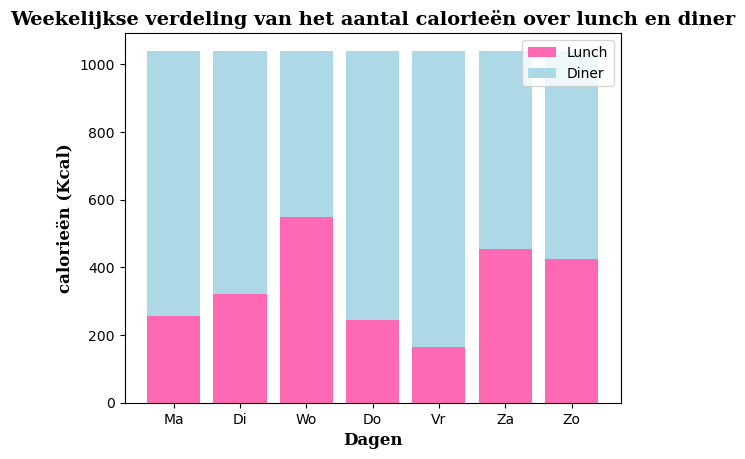

In [35]:
font1 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }

font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

plt.bar(DAGPLT, Kcal_lunch, color='hotpink', linewidth = 1.5)
plt.bar(DAGPLT, Kcal_diner, bottom=Kcal_lunch, color='lightblue')
plt.xlabel('Dagen', fontdict = font2)
plt.ylabel('calorieën (Kcal)', fontdict = font2)
plt.title("Weekelijkse verdeling van het aantal calorieën over lunch en diner", fontdict = font1)
plt.legend(["Lunch", "Diner"])
plt.show()
#Figuur.savefig('Kcal_verloop_per_week_V2.jpeg', dpi = 100)